## CUSTOMER CHURN PREDICTION - ML PIPELINE

### Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

### Load and Inspect Dataset

In [4]:
df = pd.read_excel('Telco_customer_churn.xlsx')

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes.value_counts())
print(f"\nMissing Values:")
print(df.isnull().sum().sum(), "total missing values")

DATASET OVERVIEW
Dataset Shape: 7043 rows, 33 columns

First 5 rows:
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   


### Data Cleaning & Preprocessing

In [5]:
# Clean column names
df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_").str.lower()

# Drop unnecessary columns
drop_cols = ['lat_long', 'latitude', 'longitude', 'country', 'state', 
             'city', 'zip_code', 'count', 'churn_reason', 'customerid']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Fix data types
if df['senior_citizen'].dtype == 'object':
    df['senior_citizen'] = df['senior_citizen'].replace({'Yes': 1, 'No': 0})
df['senior_citizen'] = df['senior_citizen'].astype(int)

# Convert total_charges to numeric and handle missing values
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df['total_charges'] = df['total_charges'].fillna(df['total_charges'].median())

# Encode binary Yes/No columns
binary_cols = [col for col in df.columns 
               if df[col].dtype == 'object' and df[col].nunique() == 2]
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

# One-hot encode categorical columns
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Remove target leakage columns
leak_cols = ['churn_label', 'churn_score']
df = df.drop(columns=[col for col in leak_cols if col in df.columns], errors='ignore')

print("\n" + "="*60)
print("DATA CLEANING COMPLETED")
print("="*60)
print(f"Final Shape: {df.shape}")
print(f"No missing values: {df.isnull().sum().sum() == 0}")


DATA CLEANING COMPLETED
Final Shape: (7043, 32)
No missing values: True


### Feature Engineering

In [6]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Create tenure groups
df['tenure_group'] = pd.cut(df['tenure_months'], 
                            bins=[0, 12, 24, 48, 72], 
                            labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'],
                            include_lowest=True)

# Create charge groups
df['charge_group'] = pd.cut(df['monthly_charges'], 
                            bins=[0, 35, 70, 120], 
                            labels=['Low', 'Medium', 'High'],
                            include_lowest=True)

# Count services used
service_keywords = ['internet_service', 'online_security', 'online_backup', 
                   'device_protection', 'tech_support', 'streaming']
service_cols = [col for col in df.columns if any(kw in col for kw in service_keywords)]
df['total_services'] = df[service_cols].sum(axis=1)

# Customer value score
df['value_score'] = (
    (df['monthly_charges'] / df['monthly_charges'].max()) * 0.5 +
    (df['tenure_months'] / df['tenure_months'].max()) * 0.5
)

# One-hot encode new categorical features
new_cats = ['tenure_group', 'charge_group']
df = pd.get_dummies(df, columns=new_cats, drop_first=True)

print(f"Features created successfully")
print(f"New shape: {df.shape}")
print(f"New features: tenure_group, charge_group, total_services, value_score")


FEATURE ENGINEERING
Features created successfully
New shape: (7043, 39)
New features: tenure_group, charge_group, total_services, value_score


### Exploratory Data Analysis (EDA)


EXPLORATORY DATA ANALYSIS

Churn Distribution:
Not Churned: 5174 (73.46%)
Churned: 1869 (26.54%)

⚠️  Class Imbalance Detected - Will handle during modeling


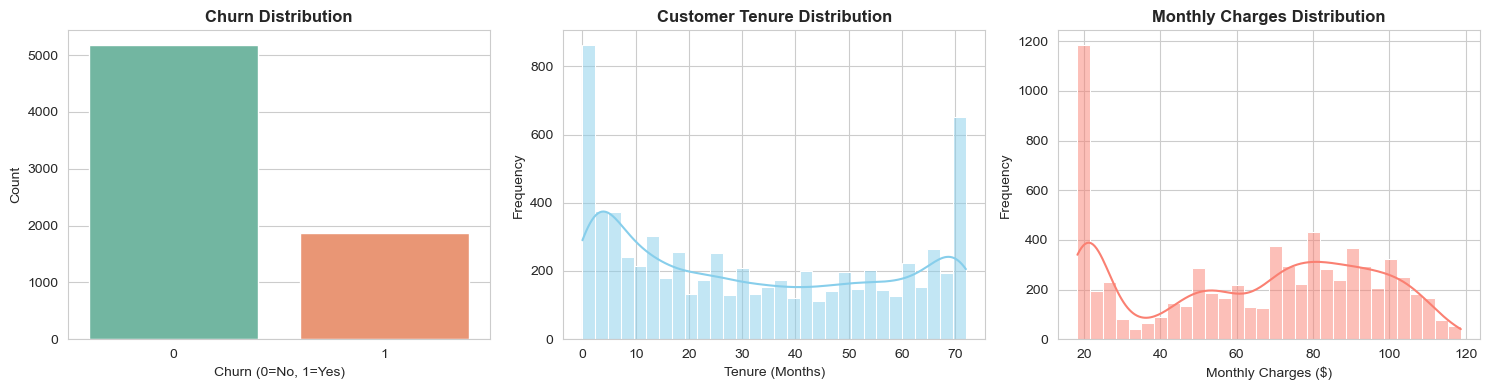

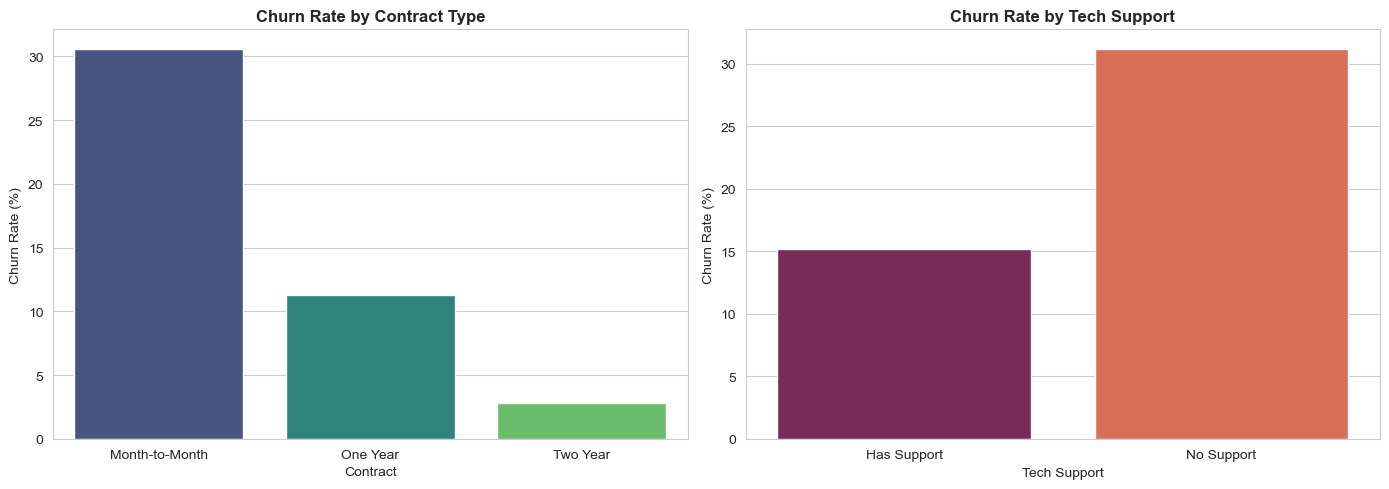

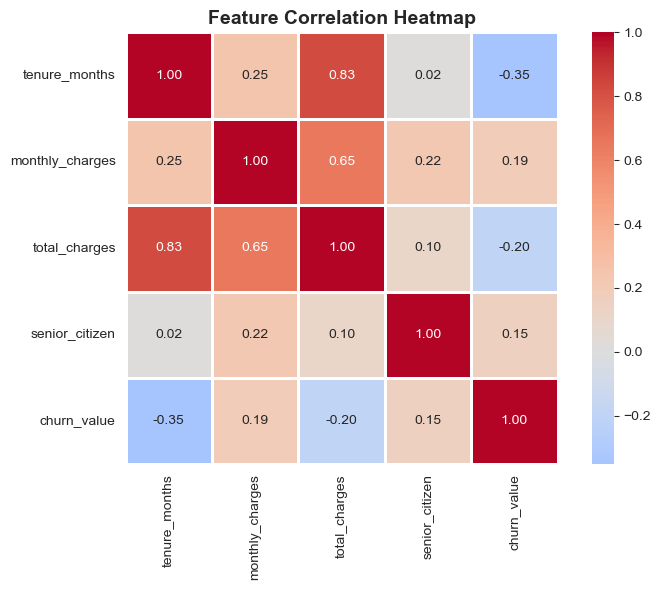

In [7]:
print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

churn_counts = df['churn_value'].value_counts()
churn_rate = df['churn_value'].value_counts(normalize=True) * 100
print(f"\nChurn Distribution:")
print(f"Not Churned: {churn_counts[0]} ({churn_rate[0]:.2f}%)")
print(f"Churned: {churn_counts[1]} ({churn_rate[1]:.2f}%)")
print(f"\n⚠️  Class Imbalance Detected - Will handle during modeling")

# Visualization 1: Churn Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.countplot(data=df, x='churn_value', ax=axes[0], palette='Set2')
axes[0].set_title('Churn Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0].set_ylabel('Count')

# Visualization 2: Tenure Distribution
sns.histplot(df['tenure_months'], bins=30, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Customer Tenure Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tenure (Months)')
axes[1].set_ylabel('Frequency')

# Visualization 3: Monthly Charges Distribution
sns.histplot(df['monthly_charges'], bins=30, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Monthly Charges Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Monthly Charges ($)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualization 4: Churn by Key Features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contract Type Analysis
contract_data = pd.DataFrame({
    'Contract': ['Month-to-Month', 'One Year', 'Two Year'],
    'Churn Rate': [
        df[df.get('contract_One year', pd.Series([0]*len(df))) == 0]['churn_value'].mean() * 100,
        df[df.get('contract_One year', pd.Series([0]*len(df))) == 1]['churn_value'].mean() * 100,
        df[df.get('contract_Two year', pd.Series([0]*len(df))) == 1]['churn_value'].mean() * 100
    ]
})
sns.barplot(data=contract_data, x='Contract', y='Churn Rate', ax=axes[0], palette='viridis')
axes[0].set_title('Churn Rate by Contract Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Churn Rate (%)')

# Tech Support Analysis
if 'tech_support_Yes' in df.columns:
    tech_data = pd.DataFrame({
        'Tech Support': ['Has Support', 'No Support'],
        'Churn Rate': [
            df[df['tech_support_Yes'] == 1]['churn_value'].mean() * 100,
            df[df['tech_support_Yes'] == 0]['churn_value'].mean() * 100
        ]
    })
    sns.barplot(data=tech_data, x='Tech Support', y='Churn Rate', ax=axes[1], palette='rocket')
    axes[1].set_title('Churn Rate by Tech Support', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Churn Rate (%)')

plt.tight_layout()
plt.show()

# Visualization 5: Correlation Heatmap
numeric_cols = ['tenure_months', 'monthly_charges', 'total_charges', 'senior_citizen', 'churn_value']
available_cols = [col for col in numeric_cols if col in df.columns]

plt.figure(figsize=(8, 6))
sns.heatmap(df[available_cols].corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Prepare Data for Modeling

In [8]:
# Separate features and target
X = df.drop('churn_value', axis=1)
y = df['churn_value']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=np.number).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("\n" + "="*60)
print("DATA PREPARATION COMPLETED")
print("="*60)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {X_train.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))


DATA PREPARATION COMPLETED
Training set: (5634, 38)
Test set: (1409, 38)
Features: 38

Class distribution in training set:
churn_value
0    0.734647
1    0.265353
Name: proportion, dtype: float64


### Model Training & Evaluation


MODEL TRAINING (WITH CLASS IMBALANCE HANDLING)

Training Logistic Regression...

Training Random Forest...

Training XGBoost...

MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.7488     0.5175  0.7888    0.6250   0.8492
      Random Forest    0.7764     0.5598  0.7380    0.6367   0.8512
            XGBoost    0.7771     0.5630  0.7166    0.6306   0.8431

🏆 Best Model: Random Forest (based on F1-Score)


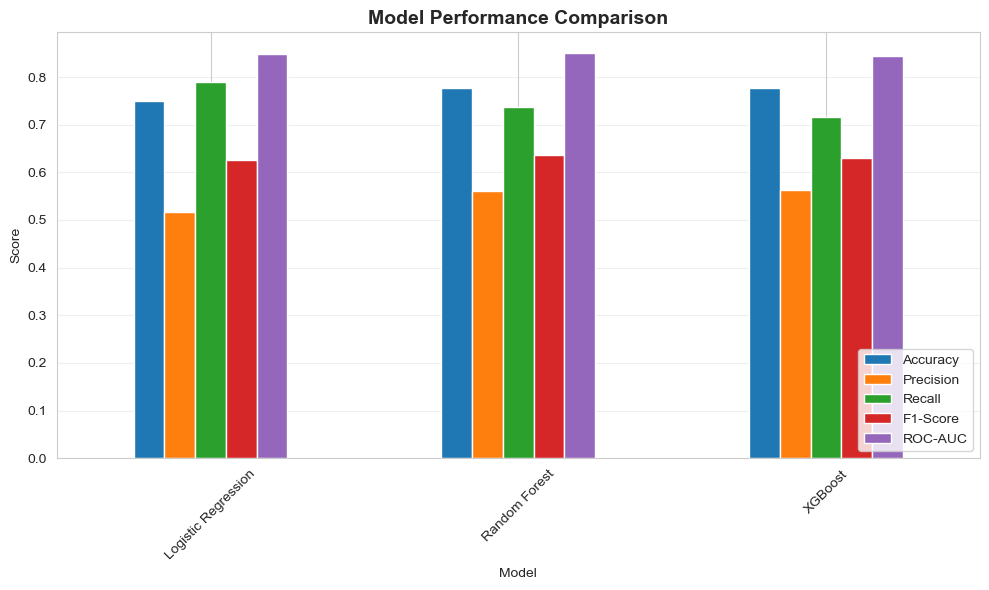

In [9]:
print("\n" + "="*60)
print("MODEL TRAINING (WITH CLASS IMBALANCE HANDLING)")
print("="*60)

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize models WITH class balancing
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',  # Handle class imbalance
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, 
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,  # Handle class imbalance
        random_state=42,
        eval_metric='logloss'
    )
}

# Train and evaluate each model
results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results_df.round(4).to_string(index=False))

# Find best model based on F1-Score (better for imbalanced data)
best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name} (based on F1-Score)")

# Performance comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].plot(
    kind='bar', ax=ax, rot=45
)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Best Model Detailed Evaluation


DETAILED EVALUATION - RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

 Not Churned       0.89      0.79      0.84      1035
     Churned       0.56      0.74      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.78      1409



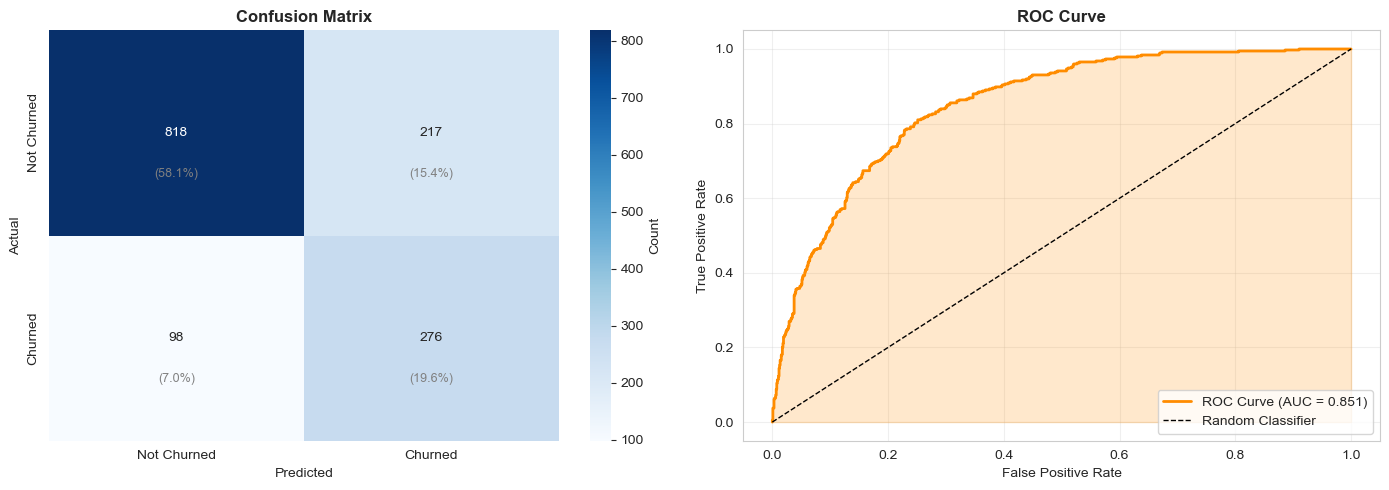


FINAL PERFORMANCE METRICS
Accuracy    : 0.7764
Precision   : 0.5598
Recall      : 0.7380
F1-Score    : 0.6367
ROC-AUC     : 0.8512

BUSINESS INSIGHTS
✓ Out of 1409 test customers:
  • 276 churners correctly identified (73.8% recall)
  • 818 non-churners correctly identified
  • 217 false alarms (predicted churn but didn't)
  • 98 missed churners (didn't predict but they churned)


In [10]:
# Select best model
best_model = trained_models[best_model_name]
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print(f"DETAILED EVALUATION - {best_model_name.upper()}")
print("="*60)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        axes[0].text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=9, color='gray')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.2, color='darkorange')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance Summary
print("\n" + "="*60)
print("FINAL PERFORMANCE METRICS")
print("="*60)
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc
}
for metric, value in metrics.items():
    print(f"{metric:12s}: {value:.4f}")

# Business Interpretation
print("\n" + "="*60)
print("BUSINESS INSIGHTS")
print("="*60)
print(f"✓ Out of {len(y_test)} test customers:")
print(f"  • {cm[1,1]} churners correctly identified ({cm[1,1]/cm[1].sum()*100:.1f}% recall)")
print(f"  • {cm[0,0]} non-churners correctly identified")
print(f"  • {cm[0,1]} false alarms (predicted churn but didn't)")
print(f"  • {cm[1,0]} missed churners (didn't predict but they churned)")

### Save Model and Artifacts

In [11]:
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names
with open('features.pkl', 'wb') as f:
    pickle.dump(list(X_train.columns), f)

print("\n" + "="*60)
print("MODEL DEPLOYMENT FILES SAVED")
print("="*60)
print("✓ churn_model.pkl - Trained model")
print("✓ scaler.pkl - Feature scaler")
print("✓ features.pkl - Feature list")
print(f"\n✓ Best model: {best_model_name}")
print("📊 Pipeline completed successfully!")
print("="*60)


MODEL DEPLOYMENT FILES SAVED
✓ churn_model.pkl - Trained model
✓ scaler.pkl - Feature scaler
✓ features.pkl - Feature list

✓ Best model: Random Forest
📊 Pipeline completed successfully!
